# EEG Demo

## Introduction
This is an example approach for RSA on EEG data. The data used here is from a project where 6 participants each saw 100 images of scenes taken from the NSD stimulus set (https://naturalscenesdataset.org). There's about 15 runs per participant, and each stimulus is shown once per run. At a later stage this data will become publicly available and we'll update this demo with instructions on how to obtain it. The data was recorded on a 128 channel Biosemi system. Here's three downsampled stimuli:

![sample1](demo_eeg_data/shared0140_nsd11797.png)
![sample2](demo_eeg_data/shared0936_nsd67830.png)
![sample3](demo_eeg_data/shared0944_nsd68742.png)

This library depends on MNE-python for convenience functions to access EEG data, and is used separately in the demo as well, so start by installing mne (`pip install mne`).
Then run the following imports:

In [46]:
%matplotlib inline
from os.path import join, expanduser, basename
import glob, json
import numpy, tqdm, mne, pandas
import rsatoolbox
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
mne.set_log_level(verbose='error')
demo_dir = './demo_eeg_data/' ## data specific for the demo, kept in the rsatoolbox repository
raw_dir = expanduser('~/data/imasem/rawdata') ## BIDS-style raw data directory
deriv_dir = expanduser('~/data/imasemrsa/epochs') ## BIDS-style derivative data directory

## Preprocess data

First we read each of the run-wise BDF (Biosemi EDF-like format) continuous data files,
preprocess it and cut the data into epochs:

- get rid of some empty channels
- apply band pass filter from 0.1 to 40Hz
- re-reference the data to the mastoids
- downsampling to 256Hz
- storing epochs files in the MNE FIF format.

In [2]:
fpaths = glob.glob(join(raw_dir, '**/*_eeg.bdf'), recursive=True)
all_epochs = []
for fpath in tqdm.tqdm(fpaths, smoothing=0):
    raw = mne.io.read_raw_bdf(fpath, preload=True)
    chans_fpath = fpath.replace('_eeg.bdf', '_channels.tsv')
    chans_df = pandas.read_csv(chans_fpath, sep='\t')

    # drop unused channels
    misc_chans = chans_df[chans_df.type=='MISC'].name.to_list()
    raw = raw.drop_channels(misc_chans)

    # filter
    raw = raw.filter(l_freq=0.1, h_freq=40)

    # rereference
    ref_chans = chans_df[chans_df.type=='REF'].name.to_list()
    raw.set_eeg_reference(ref_channels=ref_chans)

    # TODO: add nsd labels in event dict?
    events = mne.find_events(raw)
    eeg_chans = chans_df[chans_df.type=='EEG'].name.to_list()
    epochs = mne.Epochs(
        raw,
        events,
        decim=8,
        tmin=-0.2,
        tmax=+1.0,
        picks=eeg_chans,
        verbose='error'
    )
    fname = basename(fpath.replace('_eeg.bdf', '_epo.fif'))
    epochs.save(join(deriv_dir, fname))

0it [00:00, ?it/s]


### Event-Related Potential
To give you an idea of what the data looks like at this point, here's a grand-average ERP plot

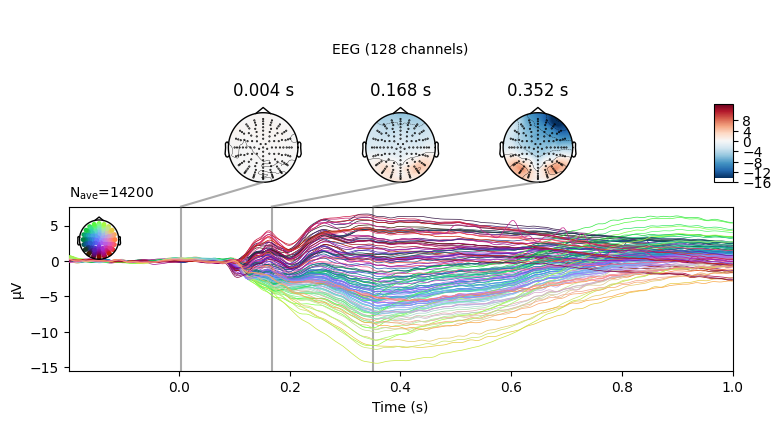

In [8]:
epoch_fpaths = glob.glob(join(deriv_dir, '*_epo.fif'))
all_epochs = [mne.read_epochs(fpath) for fpath in epoch_fpaths]
grand_avg = mne.concatenate_epochs(all_epochs).average()
grand_avg.set_montage(mne.channels.make_standard_montage('biosemi128'))
grand_avg.plot_joint()
pyplot.close()

## Importing the data to rsatoolbox

This is where the rsatoolbox library comes into play.
We use the rsatoolbox function `io.mne.read_epochs` to load each individual run,
then merge them into one large `TemporalDataset` object:

In [25]:
from rsatoolbox.io.mne import read_epochs
from rsatoolbox.data.ops import merge_datasets

fpaths = glob.glob(join(deriv_dir, f'*task-images*.fif'))

dataset = merge_datasets([read_epochs(f) for f in fpaths])

It has an internal structure of *trials x channels x samples*:

In [26]:
dataset.measurements.shape

(8000, 128, 308)

This `TemporalDataset` object keeps all descriptors that `read_epochs` created for the individual runs:

In [29]:
dataset.obs_descriptors

{'event': array([172, 180, 185, ..., 174, 148, 132], dtype=int32),
 'run': array(['11', '11', '11', ..., '14', '14', '14'], dtype='<U2'),
 'filename': array(['sub-07_ses-03_task-images_run-11_epo.fif',
        'sub-07_ses-03_task-images_run-11_epo.fif',
        'sub-07_ses-03_task-images_run-11_epo.fif', ...,
        'sub-05_ses-04_task-images_run-14_epo.fif',
        'sub-05_ses-04_task-images_run-14_epo.fif',
        'sub-05_ses-04_task-images_run-14_epo.fif'], dtype='<U40'),
 'sub': array(['07', '07', '07', ..., '05', '05', '05'], dtype='<U2')}

We will add one **observation descriptor**, which defines the structure of the data for crossvalidation. In this case we'll say that we will fold across every 3 runs. We use Python's floor division operator `//` such that runs 1-3 will be assigned to fold 0, 4-6 to fold 1, and so on.

In [33]:
RUNS_PER_FOLD = 3
folds = dataset.obs_descriptors['run'].astype(int) // RUNS_PER_FOLD
dataset.obs_descriptors['fold'] = folds
numpy.unique(folds)

array([0, 1, 2, 3, 4, 5])

### Spatiotemporal window

For the first hypothesis, we will look at a spatiotemporal window. In other words, we will consider both channels and timepoints in the window to be features of the representational patterns. First, let's select only the first 800ms:

In [78]:
dataset_window = dataset.subset_time('time', .000, .800)

Then we collapse the time dimension, to create a regular `Dataset` object where the samples are represented as *channels* (or features).

In [79]:
dataset_window_flat = dataset_window.time_as_channels()
dataset_window_flat.measurements.shape

(8000, 26240)

## Calculate data RDMs

We will create one RDM for per subject, so that later we can test our hypothesis on the sample.
This splits the dataset into a list of `Dataset` objects:

In [80]:
subject_datasets = dataset_window_flat.split_obs(by='sub')
len(subject_datasets)

6

Then pass this list to `calc_rdm` to compute the crossvalidated mahalanobis or crossnobis dissimilarity:

In [81]:
from rsatoolbox.rdm.calc import calc_rdm
data_rdms = calc_rdm(subject_datasets, method='crossnobis', descriptor='event', cv_descriptor='fold')

Let's plot the six participant RDMs. They don't have as much obvious structure as we are used to from single-object image studies; after all these are scenes, so their representations reflect multiple things and there is no obvious way to order the conditions to match attributes of the things depicted.

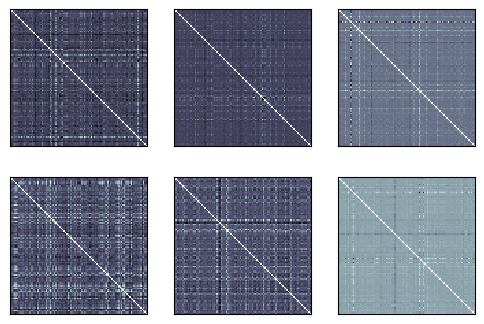

In [82]:
fig, _, _ = rsatoolbox.vis.show_rdm(data_rdms)
pyplot.show()

## Annotations

For the purpose of this demo we asked two participants to annotate the stimuli. They each viewed the 100 scene images one by one in a [Meadows "Stimulus Form" task](https://meadows-research.com). They rated the distance of the most prominent item, the presence of animate beings, whether the scene is out- or indoors, and the dominant color.

![example of annotation interface on Meadows](demo_eeg_data/annotate.png)

### Preprocess the annotation data

Here we read each of the two participants' data files. We have to convert some of the values to numerical format such that we can calculate a meaningful distance later. We then keep them around as Pandas Dataframe objects.

In [83]:
fpaths = glob.glob(join(demo_dir, '*_annotations.csv'))
subject_dfs = []
for fpath in fpaths:
    df_raw = pandas.read_csv(fpath)
    df = pandas.json_normalize(df_raw.label.apply(json.loads).tolist())
    df['animacy'] = df.animacy.str.contains('Yes').astype(float)
    df['in_out'] = df.inoutdoors.str.contains('Indoor').astype(float)
    df['r'] = (df.color == 'red').astype(float)
    df['g'] = (df.color == 'green').astype(float)
    df['b'] = (df.color == 'blue').astype(float)
    dist_unscaled = df.distance.astype(float).values.reshape(-1, 1)
    df['distance'] = MinMaxScaler().fit_transform(dist_unscaled).squeeze()
    df['sub'] = basename(fpath).split('_')[-3]
    df['nsd'] = df_raw.stim1_name
    df = df.drop(['inoutdoors', 'color'], axis=1)
    subject_dfs.append(df)

subject_dfs[0].sample(7)

,distance,animacy,in_out,r,g,b,sub,nsd
55,0.292929,1.0,0.0,1.0,0.0,0.0,devoted-caiman,shared0876_nsd63932
1,0.565657,1.0,0.0,1.0,0.0,0.0,devoted-caiman,shared0404_nsd30396
37,0.171717,1.0,1.0,1.0,0.0,0.0,devoted-caiman,shared0974_nsd70506
80,0.767677,0.0,0.0,0.0,0.0,1.0,devoted-caiman,shared0186_nsd15365
72,0.757576,0.0,0.0,0.0,1.0,0.0,devoted-caiman,shared0487_nsd36975
64,0.161616,0.0,1.0,1.0,0.0,0.0,devoted-caiman,shared0064_nsd06522
16,0.606061,1.0,0.0,0.0,0.0,1.0,devoted-caiman,shared0362_nsd27436


We can now convert these pandas DataFrames to an rsatoolbox Dataset:

In [84]:
from rsatoolbox.data.dataset import Dataset

group_df = pandas.concat(subject_dfs)
annot_dataset = Dataset.from_df(group_df)
annot_dataset.channel_descriptors

{'name': ['distance', 'animacy', 'in_out', 'r', 'g', 'b']}

### Calulcate Annotation RDMs

Then we make an RDM for each of the features annotated.

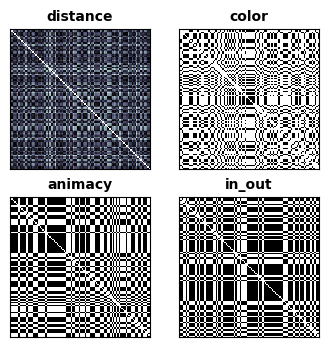

In [85]:
from rsatoolbox.rdm.rdms import concat

annot_rdm_list = []
for channel in ('animacy', 'in_out', 'distance', 'color'):
    channel_values = ['r', 'g', 'b'] if channel == 'color' else channel
    annot_rdm = calc_rdm(
        annot_dataset.subset_channel('name', channel_values),
        method='euclidean',
        descriptor='nsd'
    )
    annot_rdm.rdm_descriptors['name'] = [channel]
    annot_rdm_list.append(annot_rdm)
annot_rdms = concat(annot_rdm_list)
annot_rdms.dissimilarities = numpy.sqrt(annot_rdms.dissimilarities)
fig, _, _ = rsatoolbox.vis.show_rdm(annot_rdms, rdm_descriptor='name')
pyplot.show()

## Modelling

Now that we have RDMs from the EEG data, as well as annotation RDMs that can serve as a model, we can test our hypothesis.

First, we wrap each of the annotation RDMs in their own fixed `Model` object.

In [114]:
from rsatoolbox.model.model import ModelFixed

models = []
for model_name in annot_rdms.rdm_descriptors['name']:
    model_rdm = annot_rdms.subset('name', model_name)
    models.append(ModelFixed(model_name, model_rdm))

Let's see how well each of these models explains the EEG data RDMs

In [118]:
from rsatoolbox.inference.evaluate import eval_fixed, eval_dual_bootstrap

eval_result = eval_fixed(models, data_rdms)
print(eval_result)

Results for running fixed evaluation for cosine on 4 models:

Model    |   Eval ± SEM   | p (against 0) | p (against NC) |
------------------------------------------------------------
animacy  |  0.131 ± 0.018 |      < 0.001  |         0.041  |
in_out   |  0.105 ± 0.012 |      < 0.001  |         0.112  |
distance |  0.148 ± 0.018 |      < 0.001  |         0.014  |
color    |  0.138 ± 0.015 |      < 0.001  |         0.013  |

p-values are based on uncorrected t-tests


Next let's plot a comparison of the models:

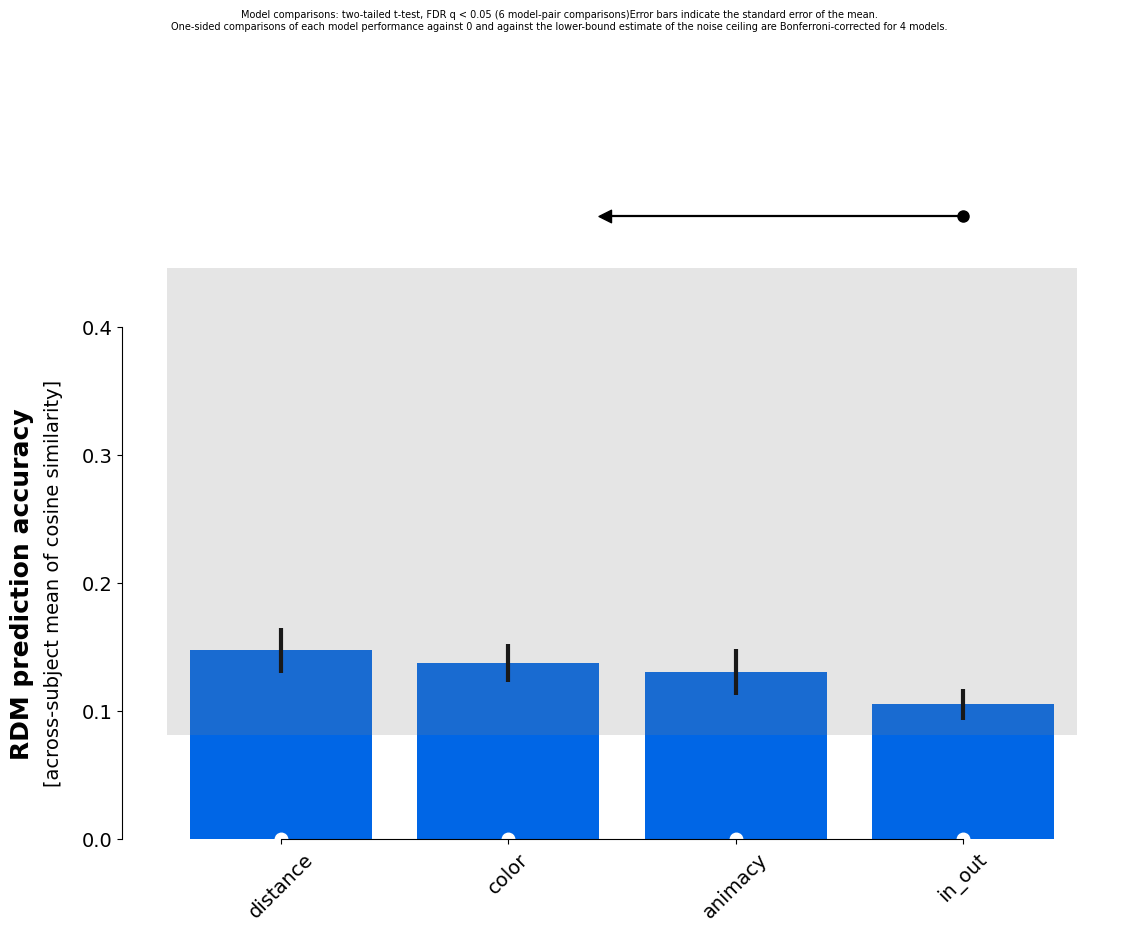

In [120]:
from rsatoolbox.vis.model_plot import plot_model_comparison

fig, _, _ = plot_model_comparison(eval_result, sort=True)
pyplot.show()

It looks like the distance, color and animacy dimensions explain a significant part of the variance in the RDM, whereas the in/outdoor distinction is less predictive. Keep in mind that "color" here, is likely associated with other aspects of the scenes. Outdoor scenes are more likely to feature green grass and foliage for instance.